# Quantitative Value Strategy
"Value investing" means investing in the stocks that are cheapest relative to common measures of business value (like earnings or assets).

For this project, we're going to build an investing strategy that selects the 50 stocks with the best value metrics. From there, we will calculate recommended trades for an equal-weight portfolio of these 50 stocks.

## Library Imports
The first thing we need to do is import the open-source software libraries that we'll be using in this tutorial.

In [40]:
pip install xlsxwriter pandas numpy spicy

In [41]:
import numpy as np
import pandas as pd
import xlsxwriter
import math
import requests
from spicy import stats

## Importing Our List of Stocks & API Token
As before, we'll need to import our list of stocks and our API token before proceeding. Make sure the .csv file is still in your working directory and import it with the following command:

In [42]:
stocks = pd.read_csv('/content/sp500.csv')
stocks

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [43]:
from google.colab import userdata
API_TOKEN = userdata.get('API_TOKEN')

## Making Our First API Call
It's now time to make the first version of our value screener!

We'll start by building a simple value screener that ranks securities based on a single metric (the price-to-earnings ratio).

In [ ]:
symbol = 'AAPL'
api_url = f'https://cloud.iexapis.com/stable/stock/{symbol}/stats?token={API_TOKEN}'
data = requests.get(api_url).json()
data

## Parsing Our API Call
This API call has the metric we need - the price-to-earnings ratio.

Here is an example of how to parse the metric from our API call:

In [ ]:
data['peRatio']

## Executing A Batch API Call & Building Our DataFrame

Just like in our first project, it's now time to execute several batch API calls and add the information we need to our DataFrame.

We'll start by running the following code cell, which contains some code we already built last time that we can re-use for this project. More specifically, it contains a function called chunks that we can use to divide our list of securities into groups of 100.

In [ ]:
# Function sourced from
# https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

symbol_groups = list(chunks(stocks['Symbol'], 100))
symbol_strings = []
for i in range(0, len(symbol_groups)):
    symbol_strings.append(','.join(symbol_groups[i]))
#     print(symbol_strings[i])

my_columns = ['Ticker', 'Price', 'Price-to-Earnings Ratio']

Now we need to create a blank DataFrame and add our data to the data frame one-by-one.

In [44]:
final_dataframe = pd.DataFrame(columns = my_columns)

for symbol_string in symbol_strings:
#     print(symbol_strings)
    batch_api_call_url = f'https://cloud.iexapis.com/stable/stock/market/batch/?types=stats,quote&symbols={symbol_string}&token={API_TOKEN}'
    data = requests.get(batch_api_call_url).json()
    for symbol in symbol_string.split(','):
        final_dataframe = final_dataframe._append(
                                        pd.Series([symbol,
                                                   data[symbol]['quote']['latestPrice'],
                                                   data[symbol]['stats']['peRatio']
                                                   ],
                                                  index = my_columns),
                                        ignore_index = True)


final_dataframe

,Ticker,Price,Price-to-Earnings Ratio
0,MMM,105.26,-8.270170
1,AOS,85.68,17.926125
2,ABT,104.09,32.163140
3,ABBV,166.42,49.382577
4,ACN,303.59,28.946914
...,...,...,...
498,XYL,143.32,52.409565
499,YUM,141.66,24.764754
500,ZBRA,317.89,62.627257
501,ZBH,120.18,25.653080


## Removing Glamour Stocks

The opposite of a "value stock" is a "glamour stock".

Since the goal of this strategy is to identify the 50 best value stocks from our universe, our next step is to remove glamour stocks from the DataFrame.

We'll sort the DataFrame by the stocks' price-to-earnings ratio, and drop all stocks outside the top 50.

In [45]:
final_dataframe.sort_values('Price-to-Earnings Ratio', inplace = True)
final_dataframe = final_dataframe[final_dataframe['Price-to-Earnings Ratio'] > 0]
final_dataframe = final_dataframe[:50]
final_dataframe.reset_index(inplace = True)
final_dataframe.drop('index', axis = 1, inplace = True)
final_dataframe

,Ticker,Price,Price-to-Earnings Ratio
0,APA,30.88,4.175745
1,GM,45.76,4.914830
2,BALL,70.11,5.162653
3,EG,392.92,5.916706
4,EMR,112.88,6.016831
5,SYF,43.94,6.109359
6,UAL,54.97,6.724079
7,BAX,35.25,6.780937
8,DAL,52.70,6.789371
9,FMC,63.98,7.127022


## Calculating the Number of Shares to Buy
We now need to calculate the number of shares we need to buy.

To do this, we will use the `portfolio_input` function that we created in our momentum project.

I have included this function below.

In [46]:
def portfolio_input():
    global portfolio_size
    portfolio_size = input("Enter the value of your portfolio:")

    try:
        val = float(portfolio_size)
    except ValueError:
        print("That's not a number! \n Try again:")
        portfolio_size = input("Enter the value of your portfolio:")

Use the `portfolio_input` function to accept a `portfolio_size` variable from the user of this script.

In [47]:
portfolio_input()

Enter the value of your portfolio:2500000


You can now use the global `portfolio_size` variable to calculate the number of shares that our strategy should purchase.

In [48]:
position_size = float(portfolio_size) / len(final_dataframe.index)
for i in range(0, len(final_dataframe['Ticker'])-1):
    final_dataframe.loc[i, 'Number Of Shares to Buy'] = math.floor(position_size / final_dataframe['Price'][i])
final_dataframe

,Ticker,Price,Price-to-Earnings Ratio,Number Of Shares to Buy
0,APA,30.88,4.175745,1619.0
1,GM,45.76,4.914830,1092.0
2,BALL,70.11,5.162653,713.0
3,EG,392.92,5.916706,127.0
4,EMR,112.88,6.016831,442.0
5,SYF,43.94,6.109359,1137.0
6,UAL,54.97,6.724079,909.0
7,BAX,35.25,6.780937,1418.0
8,DAL,52.70,6.789371,948.0
9,FMC,63.98,7.127022,781.0


## Building a Better (and More Realistic) Value Strategy
Every valuation metric has certain flaws.

For example, the price-to-earnings ratio doesn't work well with stocks with negative earnings.

Similarly, stocks that buyback their own shares are difficult to value using the price-to-book ratio.

Investors typically use a `composite` basket of valuation metrics to build robust quantitative value strategies. In this section, we will filter for stocks with the lowest percentiles on the following metrics:

* Price-to-earnings ratio
* Price-to-book ratio
* Price-to-sales ratio
* Enterprise Value divided by Earnings Before Interest, Taxes, Depreciation, and Amortization (EV/EBITDA)
* Enterprise Value divided by Gross Profit (EV/GP)

Some of these metrics aren't provided directly by the IEX Cloud API, and must be computed after pulling raw data. We'll start by calculating each data point from scratch.

In [49]:
symbol = 'AAPL'
batch_api_call_url = f'https://cloud.iexapis.com/stable/stock/market/batch/?types=advanced-stats,quote&symbols={symbol}&token={API_TOKEN}'
data = requests.get(batch_api_call_url).json()

# P/E Ratio
pe_ratio = data[symbol]['quote']['peRatio']

# P/B Ratio
pb_ratio = data[symbol]['advanced-stats']['priceToBook']

#P/S Ratio
ps_ratio = data[symbol]['advanced-stats']['priceToSales']

# EV/EBITDA
enterprise_value = data[symbol]['advanced-stats']['enterpriseValue']
ebitda = data[symbol]['advanced-stats']['EBITDA']
ev_to_ebitda = enterprise_value/ebitda

# EV/GP
gross_profit = data[symbol]['advanced-stats']['grossProfit']
ev_to_gross_profit = enterprise_value/gross_profit

Let's move on to building our DataFrame. You'll notice that I use the abbreviation `rv` often. It stands for `robust value`, which is what we'll call this sophisticated strategy moving forward.

In [50]:
rv_columns = [
    'Ticker',
    'Price',
    'Price-to-Earnings Ratio',
    'PE Percentile',
    'Price-to-Book Ratio',
    'PB Percentile',
    'Price-to-Sales Ratio',
    'PS Percentile',
    'EV/EBITDA',
    'EV/EBITDA Percentile',
    'EV/GP',
    'EV/GP Percentile',
    'RV Score',
    'One-Year Price Return',
    'Six-Month Price Return',
    'Three-Month Price Return',
    'One-Month Price Return'
]

rv_dataframe = pd.DataFrame(columns = rv_columns)

for symbol_string in symbol_strings:
    batch_api_call_url = f'https://cloud.iexapis.com/stable/stock/market/batch/?types=advanced-stats,quote&symbols={symbol_string}&token={API_TOKEN}'
    data = requests.get(batch_api_call_url).json()
    for symbol in symbol_string.split(','):
        enterprise_value = data[symbol]['advanced-stats']['enterpriseValue']
        ebitda = data[symbol]['advanced-stats']['EBITDA']
        gross_profit = data[symbol]['advanced-stats']['grossProfit']

        try:
            ev_to_ebitda = enterprise_value/ebitda
        except TypeError:
            ev_to_ebitda = np.NaN

        try:
            ev_to_gross_profit = enterprise_value/gross_profit
        except TypeError:
            ev_to_gross_profit = np.NaN

        rv_dataframe = rv_dataframe._append(
            pd.Series([
                symbol,
                data[symbol]['quote']['latestPrice'],
                data[symbol]['quote']['peRatio'],
                'N/A',
                data[symbol]['advanced-stats']['priceToBook'],
                'N/A',
                data[symbol]['advanced-stats']['priceToSales'],
                'N/A',
                ev_to_ebitda,
                'N/A',
                ev_to_gross_profit,
                'N/A',
                'N/A',
                data[symbol]['advanced-stats']['year1ChangePercent'],
                data[symbol]['advanced-stats']['month6ChangePercent'],
                data[symbol]['advanced-stats']['month3ChangePercent'],
                data[symbol]['advanced-stats']['month1ChangePercent']
        ],
        index = rv_columns),
            ignore_index = True
        )

In [51]:
rv_dataframe

,Ticker,Price,Price-to-Earnings Ratio,PE Percentile,Price-to-Book Ratio,PB Percentile,Price-to-Sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score,One-Year Price Return,Six-Month Price Return,Three-Month Price Return,One-Month Price Return
0,MMM,105.26,-9.91,N/A,11.97,N/A,1.78,N/A,-9.903230,N/A,4.750263,N/A,N/A,0.107163,0.122387,0.153534,0.150634
1,AOS,85.68,22.25,N/A,5.50,N/A,2.68,N/A,12.077168,N/A,6.797748,N/A,N/A,0.259956,0.130520,0.073926,-0.007835
2,ABT,104.09,32.33,N/A,4.67,N/A,4.49,N/A,22.767222,N/A,8.506840,N/A,N/A,-0.020925,0.055867,-0.082482,-0.011209
3,ABBV,166.42,49.53,N/A,36.70,N/A,5.40,N/A,15.860699,N/A,10.324903,N/A,N/A,0.207302,0.226168,-0.053613,0.010689
4,ACN,303.59,27.55,N/A,7.50,N/A,3.15,N/A,16.211389,N/A,9.440007,N/A,N/A,0.072289,-0.066960,-0.175150,-0.039272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,XYL,143.32,50.46,N/A,3.41,N/A,4.37,N/A,27.367634,N/A,12.340247,N/A,N/A,0.390018,0.425548,0.161144,0.127084
499,YUM,141.66,25.07,N/A,-5.14,N/A,5.68,N/A,20.609734,N/A,9.591483,N/A,N/A,0.042854,0.120495,0.058112,0.027490
500,ZBRA,317.89,62.95,N/A,5.16,N/A,3.75,N/A,29.336080,N/A,9.066723,N/A,N/A,0.138045,0.458077,0.154033,0.164304
501,ZBH,120.18,26.01,N/A,1.96,N/A,3.32,N/A,14.756154,N/A,5.623871,N/A,N/A,-0.103028,0.080381,-0.034512,0.007123


## Dealing With Missing Data in Our DataFrame

Our DataFrame contains some missing data because all of the metrics we require are not available through the API we're using.

You can use pandas' `isnull` method to identify missing data:

In [52]:
rv_dataframe[rv_dataframe.isnull().any(axis=1)]

,Ticker,Price,Price-to-Earnings Ratio,PE Percentile,Price-to-Book Ratio,PB Percentile,Price-to-Sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score,One-Year Price Return,Six-Month Price Return,Three-Month Price Return,One-Month Price Return
37,AON,292.45,NaN,N/A,NaN,N/A,NaN,N/A,NaN,N/A,NaN,N/A,N/A,-0.090423,-0.109120,-0.058109,-0.050359
194,FRT,102.33,NaN,N/A,NaN,N/A,NaN,N/A,NaN,N/A,NaN,N/A,N/A,0.197650,0.129334,0.029945,0.038567
267,J,136.44,NaN,N/A,NaN,N/A,NaN,N/A,NaN,N/A,NaN,N/A,N/A,0.181108,0.010304,-0.073375,-0.049199
386,PSA,288.67,NaN,N/A,NaN,N/A,NaN,N/A,NaN,N/A,NaN,N/A,N/A,0.018344,0.144220,0.036054,0.109075
420,SOLV,62.38,NaN,N/A,NaN,N/A,NaN,N/A,NaN,N/A,NaN,N/A,N/A,-0.220250,-0.220250,-0.220250,-0.025769


Dealing with missing data is an important topic in data science.

There are two main approaches:

* Drop missing data from the data set (pandas' `dropna` method is useful here)
* Replace missing data with a new value (pandas' `fillna` method is useful here)

In this tutorial, we will replace missing data with the average non-`NaN` data point from that column.

Here is the code to do this:

In [53]:
for column in ['Price-to-Earnings Ratio', 'Price-to-Book Ratio','Price-to-Sales Ratio',  'EV/EBITDA','EV/GP']:
    rv_dataframe[column].fillna(rv_dataframe[column].mean(), inplace = True)

Now, if we run the statement from earlier to print rows that contain missing data, nothing should be returned:

In [54]:
rv_dataframe[rv_dataframe.isnull().any(axis=1)]

,Ticker,Price,Price-to-Earnings Ratio,PE Percentile,Price-to-Book Ratio,PB Percentile,Price-to-Sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score,One-Year Price Return,Six-Month Price Return,Three-Month Price Return,One-Month Price Return


## Calculating Value Percentiles

We now need to calculate value score percentiles for every stock in the universe. More specifically, we need to calculate percentile scores for the following metrics for every stock:

* Price-to-earnings ratio
* Price-to-book ratio
* Price-to-sales ratio
* EV/EBITDA
* EV/GP

Here's how we'll do this:

In [55]:
metrics = {
            'Price-to-Earnings Ratio': 'PE Percentile',
            'Price-to-Book Ratio':'PB Percentile',
            'Price-to-Sales Ratio': 'PS Percentile',
            'EV/EBITDA':'EV/EBITDA Percentile',
            'EV/GP':'EV/GP Percentile'
}

for row in rv_dataframe.index:
    for metric in metrics.keys():
        rv_dataframe.loc[row, metrics[metric]] = stats.percentileofscore(rv_dataframe[metric], rv_dataframe.loc[row, metric])/100

# Print each percentile score to make sure it was calculated properly
# for metric in metrics.values():
#     print(rv_dataframe[metric])

#Print the entire DataFrame
rv_dataframe

,Ticker,Price,Price-to-Earnings Ratio,PE Percentile,Price-to-Book Ratio,PB Percentile,Price-to-Sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score,One-Year Price Return,Six-Month Price Return,Three-Month Price Return,One-Month Price Return
0,MMM,105.26,-9.91,0.049702,11.97,0.882704,1.78,0.314115,-9.903230,0.011928,4.750263,0.294235,N/A,0.107163,0.122387,0.153534,0.150634
1,AOS,85.68,22.25,0.457256,5.50,0.675944,2.68,0.482107,12.077168,0.349901,6.797748,0.459245,N/A,0.259956,0.130520,0.073926,-0.007835
2,ABT,104.09,32.33,0.699801,4.67,0.616302,4.49,0.691849,22.767222,0.807157,8.506840,0.596421,N/A,-0.020925,0.055867,-0.082482,-0.011209
3,ABBV,166.42,49.53,0.87674,36.70,0.972167,5.40,0.740557,15.860699,0.532803,10.324903,0.699801,N/A,0.207302,0.226168,-0.053613,0.010689
4,ACN,303.59,27.55,0.606362,7.50,0.7833,3.15,0.550696,16.211389,0.560636,9.440007,0.654076,N/A,0.072289,-0.066960,-0.175150,-0.039272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,XYL,143.32,50.46,0.884692,3.41,0.522863,4.37,0.673956,27.367634,0.872763,12.340247,0.805169,N/A,0.390018,0.425548,0.161144,0.127084
499,YUM,141.66,25.07,0.538767,-5.14,0.059642,5.68,0.756461,20.609734,0.757455,9.591483,0.667992,N/A,0.042854,0.120495,0.058112,0.027490
500,ZBRA,317.89,62.95,0.920477,5.16,0.650099,3.75,0.612326,29.336080,0.898608,9.066723,0.622266,N/A,0.138045,0.458077,0.154033,0.164304
501,ZBH,120.18,26.01,0.564612,1.96,0.296223,3.32,0.5666,14.756154,0.491054,5.623871,0.361829,N/A,-0.103028,0.080381,-0.034512,0.007123


## Calculating the RV Score
We'll now calculate our RV Score (which stands for Robust Value), which is the value score that we'll use to filter for stocks in this investing strategy.

The RV Score will be the arithmetic mean of the 4 percentile scores that we calculated in the last section.

To calculate arithmetic mean, we will use the mean function from Python's built-in statistics module.

In [56]:
from statistics import mean

for row in rv_dataframe.index:
    value_percentiles = []
    for metric in metrics.keys():
        value_percentiles.append(rv_dataframe.loc[row, metrics[metric]])
    rv_dataframe.loc[row, 'RV Score'] = mean(value_percentiles)

rv_dataframe

,Ticker,Price,Price-to-Earnings Ratio,PE Percentile,Price-to-Book Ratio,PB Percentile,Price-to-Sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score,One-Year Price Return,Six-Month Price Return,Three-Month Price Return,One-Month Price Return
0,MMM,105.26,-9.91,0.049702,11.97,0.882704,1.78,0.314115,-9.903230,0.011928,4.750263,0.294235,0.310537,0.107163,0.122387,0.153534,0.150634
1,AOS,85.68,22.25,0.457256,5.50,0.675944,2.68,0.482107,12.077168,0.349901,6.797748,0.459245,0.484891,0.259956,0.130520,0.073926,-0.007835
2,ABT,104.09,32.33,0.699801,4.67,0.616302,4.49,0.691849,22.767222,0.807157,8.506840,0.596421,0.682306,-0.020925,0.055867,-0.082482,-0.011209
3,ABBV,166.42,49.53,0.87674,36.70,0.972167,5.40,0.740557,15.860699,0.532803,10.324903,0.699801,0.764414,0.207302,0.226168,-0.053613,0.010689
4,ACN,303.59,27.55,0.606362,7.50,0.7833,3.15,0.550696,16.211389,0.560636,9.440007,0.654076,0.631014,0.072289,-0.066960,-0.175150,-0.039272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,XYL,143.32,50.46,0.884692,3.41,0.522863,4.37,0.673956,27.367634,0.872763,12.340247,0.805169,0.751889,0.390018,0.425548,0.161144,0.127084
499,YUM,141.66,25.07,0.538767,-5.14,0.059642,5.68,0.756461,20.609734,0.757455,9.591483,0.667992,0.556064,0.042854,0.120495,0.058112,0.027490
500,ZBRA,317.89,62.95,0.920477,5.16,0.650099,3.75,0.612326,29.336080,0.898608,9.066723,0.622266,0.740755,0.138045,0.458077,0.154033,0.164304
501,ZBH,120.18,26.01,0.564612,1.96,0.296223,3.32,0.5666,14.756154,0.491054,5.623871,0.361829,0.456064,-0.103028,0.080381,-0.034512,0.007123


## Selecting the 50 Best Value Stocks¶

As before, we can identify the 50 best value stocks in our universe by sorting the DataFrame on the RV Score column and dropping all but the top 50 entries.

In [57]:
rv_dataframe.sort_values('RV Score', ascending = True, inplace = True)
rv_dataframe = rv_dataframe[:50]
rv_dataframe.reset_index(drop = True, inplace = True)

In [58]:
rv_dataframe

,Ticker,Price,Price-to-Earnings Ratio,PE Percentile,Price-to-Book Ratio,PB Percentile,Price-to-Sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score,One-Year Price Return,Six-Month Price Return,Three-Month Price Return,One-Month Price Return
0,GM,45.76,5.64,0.069583,0.7840,0.079523,0.2986,0.023857,1.898133,0.015905,1.354342,0.073559,0.052485,0.406671,0.642050,0.185932,0.078228
1,PARA,12.02,-178.34,0.007952,0.3832,0.067594,0.2790,0.021869,8.400501,0.166998,0.685516,0.015905,0.056064,-0.212784,-0.074979,0.010296,0.095716
2,SYF,43.94,6.33,0.075547,1.2500,0.140159,0.7278,0.081511,4.114699,0.023857,0.997728,0.037773,0.071769,0.506445,0.488356,0.116890,0.082944
3,CVS,57.68,10.12,0.127237,0.9789,0.093439,0.2006,0.00994,7.023832,0.097416,0.838648,0.031809,0.071968,-0.137822,-0.145951,-0.244642,-0.160713
4,UAL,54.97,6.79,0.081511,1.9700,0.298211,0.3297,0.027833,3.899604,0.021869,0.570783,0.011928,0.08827,0.142115,0.382545,0.309121,0.069039
5,F,12.28,12.65,0.194831,1.1200,0.109344,0.2713,0.019881,3.203589,0.017893,1.727009,0.111332,0.090656,0.109505,0.224864,0.010500,0.030608
6,L,77.74,11.53,0.166004,1.0600,0.10338,1.1000,0.149105,5.154873,0.035785,1.100097,0.043738,0.099602,0.325601,0.162351,0.046616,0.052817
7,EG,392.92,5.77,0.071571,1.2500,0.140159,1.1100,0.15507,6.618455,0.083499,1.105576,0.047714,0.099602,0.045777,0.000129,0.072874,0.090808
8,AIG,80.54,11.97,0.176938,1.2300,0.131213,1.1000,0.149105,5.288071,0.039761,1.104468,0.045726,0.108549,0.516815,0.261807,0.155394,0.103439
9,FOX,30.53,9.60,0.11332,1.4000,0.162028,1.0600,0.141153,6.430036,0.078529,1.306794,0.064612,0.111928,0.094246,0.095199,0.114006,0.079180


## Calculating the Number of Shares to Buy
We'll use the `portfolio_input` function that we created earlier to accept our portfolio size. Then we will use similar logic in a for loop to calculate the number of shares to buy for each stock in our investment universe.

In [59]:
# portfolio_input()

In [60]:
position_size = float(portfolio_size)/len(rv_dataframe)

for i in range(len(rv_dataframe['Ticker'])):
  rv_dataframe.loc[i, 'Number of Shares to Buy'] = math.floor(position_size/rv_dataframe['Price'][i])

rv_dataframe

<ipython-input-60-08756b764bb9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe.loc[i, 'Number of Shares to Buy'] = math.floor(position_size/rv_dataframe['Price'][i])


,Ticker,Price,Price-to-Earnings Ratio,PE Percentile,Price-to-Book Ratio,PB Percentile,Price-to-Sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score,One-Year Price Return,Six-Month Price Return,Three-Month Price Return,One-Month Price Return,Number of Shares to Buy
0,GM,45.76,5.64,0.069583,0.7840,0.079523,0.2986,0.023857,1.898133,0.015905,1.354342,0.073559,0.052485,0.406671,0.642050,0.185932,0.078228,1092.0
1,PARA,12.02,-178.34,0.007952,0.3832,0.067594,0.2790,0.021869,8.400501,0.166998,0.685516,0.015905,0.056064,-0.212784,-0.074979,0.010296,0.095716,4159.0
2,SYF,43.94,6.33,0.075547,1.2500,0.140159,0.7278,0.081511,4.114699,0.023857,0.997728,0.037773,0.071769,0.506445,0.488356,0.116890,0.082944,1137.0
3,CVS,57.68,10.12,0.127237,0.9789,0.093439,0.2006,0.00994,7.023832,0.097416,0.838648,0.031809,0.071968,-0.137822,-0.145951,-0.244642,-0.160713,866.0
4,UAL,54.97,6.79,0.081511,1.9700,0.298211,0.3297,0.027833,3.899604,0.021869,0.570783,0.011928,0.08827,0.142115,0.382545,0.309121,0.069039,909.0
5,F,12.28,12.65,0.194831,1.1200,0.109344,0.2713,0.019881,3.203589,0.017893,1.727009,0.111332,0.090656,0.109505,0.224864,0.010500,0.030608,4071.0
6,L,77.74,11.53,0.166004,1.0600,0.10338,1.1000,0.149105,5.154873,0.035785,1.100097,0.043738,0.099602,0.325601,0.162351,0.046616,0.052817,643.0
7,EG,392.92,5.77,0.071571,1.2500,0.140159,1.1100,0.15507,6.618455,0.083499,1.105576,0.047714,0.099602,0.045777,0.000129,0.072874,0.090808,127.0
8,AIG,80.54,11.97,0.176938,1.2300,0.131213,1.1000,0.149105,5.288071,0.039761,1.104468,0.045726,0.108549,0.516815,0.261807,0.155394,0.103439,620.0
9,FOX,30.53,9.60,0.11332,1.4000,0.162028,1.0600,0.141153,6.430036,0.078529,1.306794,0.064612,0.111928,0.094246,0.095199,0.114006,0.079180,1637.0


# Calculate Returns for Various Timeframes

This code calculates the returns for different timeframes (one year, six months, three months, and one month) based on the price return data of stocks in the 'rv_dataframe'.
It assumes equal weighting for all stocks in the portfolio.

## Explanation of variables:
- one_year_return: Total return over one year period
- six_month_return: Total return over six month period
- three_month_return: Total return over three month period
- one_month_return: Total return over one month period
- position_size: Size of each position in the portfolio
- portfolio_size: Total value of the portfolio

## The returns are calculated using the formula:
```Return = (100 * Position Size * Price Return) / ((100 + Price Return) * Portfolio Size)```
- where Price Return is the price return of each stock.

### Adjust the variables 'position_size' and 'portfolio_size' as per your portfolio setup before running this code.

#### Uncomment the variables at the end of the code to view the calculated returns for each timeframe.



In [61]:
one_year_return = 0
one_month_return = 0
three_month_return = 0
six_month_return = 0
for i in range(0, len(rv_dataframe['Ticker'])-1):
  one_year_return += 100*position_size*(rv_dataframe['One-Year Price Return'][i])/((100+rv_dataframe['One-Year Price Return'][i])*float(portfolio_size))
  six_month_return += 100*position_size*(rv_dataframe['Six-Month Price Return'][i])/((100+rv_dataframe['One-Year Price Return'][i])*float(portfolio_size))
  three_month_return += 100*position_size*(rv_dataframe['Three-Month Price Return'][i])/((100+rv_dataframe['One-Year Price Return'][i])*float(portfolio_size))
  one_month_return += 100*position_size*(rv_dataframe['One-Month Price Return'][i])/((100+rv_dataframe['One-Year Price Return'][i])*float(portfolio_size))

# one_year_return
# six_month_return
# three_month_return
# one_month_return

# Investment Strategy using 80-20 Principle

#### This code implements an investment strategy based on the 80-20 principle, where 80% of the portfolio size is allocated to the top 20% stocks based on rv Score, and the remaining 20% of the portfolio size is allocated to the rest of the stocks.

## Explanation of variables:
- one_year_return_unequal_weightage: Total return over one year period with unequal weighting
- six_month_return_unequal_weightage: Total return over six month period with unequal weighting
- three_month_return_unequal_weightage: Total return over three month period with unequal weighting
- one_month_return_unequal_weightage: Total return over one month period with unequal weighting
- portfolio_size: Total value of the portfolio

### The code iterates through the stocks in 'rv_dataframe' and calculates returns for each timeframe based on the 80-20 principle.
### For the top 20% stocks, 80% of the portfolio size is allocated, and for the remaining 80% of stocks, 20% of the portfolio size is allocated.

## The returns are calculated using the formula:
```Return = (100 * Weight * Portfolio Size * Price Return) / ((100 + Price Return) * Total Weight * Portfolio Size)```
- where Weight is the allocation percentage (80% or 20%) based on the stock's position (top 20% or rest 80%).

## Adjust the variable 'portfolio_size' as per your portfolio setup before running this code.

### Uncomment the variables at the end of the code to view the calculated returns for each timeframe.


In [62]:
#If 80-20 principle is followed for investment

one_year_return_unequal_weightage = 0
six_month_return_unequal_weightage = 0
three_month_return_unequal_weightage = 0
one_month_return_unequal_weightage = 0

for i in range(0, len(rv_dataframe['Ticker'])):
  if(i<10):
    one_year_return_unequal_weightage += 100*8*float(portfolio_size)*(rv_dataframe['One-Year Price Return'][i])/((100+rv_dataframe['One-Year Price Return'][i])*100*float(portfolio_size))
    six_month_return_unequal_weightage += 100*8*float(portfolio_size)*(rv_dataframe['Six-Month Price Return'][i])/((100+rv_dataframe['One-Year Price Return'][i])*100*float(portfolio_size))
    three_month_return_unequal_weightage += 100*8*float(portfolio_size)*(rv_dataframe['Three-Month Price Return'][i])/((100+rv_dataframe['One-Year Price Return'][i])*100*float(portfolio_size))
    one_month_return_unequal_weightage += 100*8*float(portfolio_size)*(rv_dataframe['One-Month Price Return'][i])/((100+rv_dataframe['One-Year Price Return'][i])*100*float(portfolio_size))
  else:
    one_year_return_unequal_weightage += 100*5*float(portfolio_size)*(rv_dataframe['One-Year Price Return'][i])/((100+rv_dataframe['One-Year Price Return'][i])*1000*float(portfolio_size))
    six_month_return_unequal_weightage += 100*5*float(portfolio_size)*(rv_dataframe['Six-Month Price Return'][i])/((100+rv_dataframe['One-Year Price Return'][i])*1000*float(portfolio_size))
    three_month_return_unequal_weightage += 100*5*float(portfolio_size)*(rv_dataframe['Three-Month Price Return'][i])/((100+rv_dataframe['One-Year Price Return'][i])*1000*float(portfolio_size))
    one_month_return_unequal_weightage += 100*5*float(portfolio_size)*(rv_dataframe['One-Month Price Return'][i])/((100+rv_dataframe['One-Year Price Return'][i])*1000*float(portfolio_size))


# one_year_return_unequal_weightage
# six_month_return_unequal_weightage
# three_month_return_unequal_weightage
# one_month_return_unequal_weightage

# Bar Graph: Returns Comparison

 - This code generates a bar graph comparing returns under two investment strategies: Equal Weighting and Unequal Weighting (based on the 80-20 principle).
 - Timeframes include 1 month, 3 months, 6 months, and 1 year.
 - Blue bars represent Equal Weighting, while salmon bars represent Unequal Weighting.
Annotations on top display return values.

Usage: Adjust return values for each strategy and run the code to visualize the comparison.


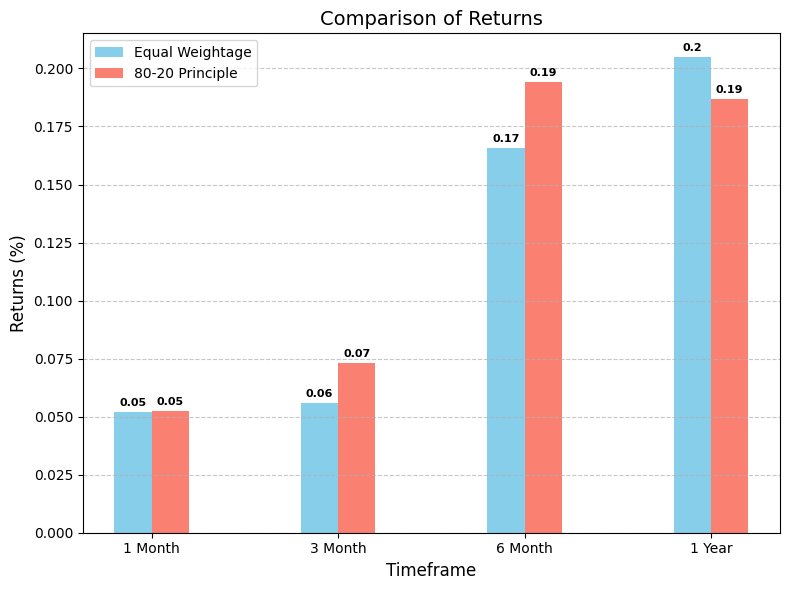

In [63]:
import matplotlib.pyplot as plt
# Define the data
labels = ['1 Month', '3 Month', '6 Month', '1 Year']
returns_equal = [one_month_return, three_month_return, six_month_return, one_year_return]
returns_unequal = [one_month_return_unequal_weightage, three_month_return_unequal_weightage, six_month_return_unequal_weightage, one_year_return_unequal_weightage]

# Create the plot
plt.figure(figsize=(8, 6))
width = 0.2
x = np.arange(len(labels))
rects1 = plt.bar(x - width/2, returns_equal, width, label='Equal Weightage', color='skyblue')
rects2 = plt.bar(x + width/2, returns_unequal, width, label='80-20 Principle', color='salmon')

# Add labels and title
plt.xlabel("Timeframe", fontsize=12)
plt.ylabel("Returns (%)", fontsize=12)
plt.title('Comparison of Returns', fontsize=14)
plt.xticks(x, labels, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)

# Add annotations
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{}'.format(round(height, 2)),  # Format the value
                     xy=(rect.get_x() + rect.get_width() / 2, height),  # Center of the bar
                     xytext=(0, 3),  # Offset text slightly above the bar
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=8, weight='bold')  # Bold annotation

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


# Bar Graph: Returns Comparison

 - This code generates a bar graph comparing returns under two investment strategies: Equal Weighting and Unequal Weighting (based on the 80-20 principle).
 - Timeframes include 1 month, 3 months, 6 months, and 1 year.
 - Blue bars represent Equal Weighting, while salmon bars represent Unequal Weighting.
Annotations on top display return values.

Usage: Adjust return values for each strategy and run the code to visualize the comparison.


## Formatting Our Excel Output

We will be using the XlsxWriter library for Python to create nicely-formatted Excel files.

XlsxWriter is an excellent package and offers tons of customization. However, the tradeoff for this is that the library can seem very complicated to new users. Accordingly, this section will be fairly long because I want to do a good job of explaining how XlsxWriter works.

In [64]:
writer = pd.ExcelWriter('value_strategy.xlsx', engine='xlsxwriter')
rv_dataframe.to_excel(writer, sheet_name='Value Strategy', index = False)

## Creating the Formats We'll Need For Our .xlsx File
You'll recall from our first project that formats include colors, fonts, and also symbols like % and $. We'll need four main formats for our Excel document:

* String format for tickers
* \$XX.XX format for stock prices
* \$XX,XXX format for market capitalization
* Integer format for the number of shares to purchase
* Float formats with 1 decimal for each valuation metric

Since we already built some formats in past sections of this course, I've included them below for you. Run this code cell before proceeding.

In [65]:
background_color = '#ffffff'
font_color = '#000000'

string_template = writer.book.add_format(
        {
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

dollar_template = writer.book.add_format(
        {
            'num_format':'$0.00',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

integer_template = writer.book.add_format(
        {
            'num_format':'0',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

float_template = writer.book.add_format(
        {
            'num_format':'0',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

percent_template = writer.book.add_format(
        {
            'num_format':'0.0%',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

In [66]:
column_formats = {
                    'A': ['Ticker', string_template],
                    'B': ['Price', dollar_template],
                    'C': ['Number of Shares to Buy', integer_template],
                    'D': ['Price-to-Earnings Ratio', float_template],
                    'E': ['PE Percentile', percent_template],
                    'F': ['Price-to-Book Ratio', float_template],
                    'G': ['PB Percentile',percent_template],
                    'H': ['Price-to-Sales Ratio', float_template],
                    'I': ['PS Percentile', percent_template],
                    'J': ['EV/EBITDA', float_template],
                    'K': ['EV/EBITDA Percentile', percent_template],
                    'L': ['EV/GP', float_template],
                    'M': ['EV/GP Percentile', percent_template],
                    'N': ['RV Score', percent_template]
                 }

for column in column_formats.keys():
    writer.sheets['Value Strategy'].set_column(f'{column}:{column}', 25, column_formats[column][1])
    writer.sheets['Value Strategy'].write(f'{column}1', column_formats[column][0], column_formats[column][1])

## Saving Our Excel Output
As before, saving our Excel output is very easy:

In [68]:
writer._save()

In [69]:
from google.colab import files
files.download('value_strategy.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>